In [1]:
import os

import cv2
import matplotlib.pyplot as plt

import numpy as np

from settings import PROJECT_ROOT

# from image_processor import JuniorFieldProcessor
# from image_processor import ImageProcessor

In [2]:
def imread_numpy(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def imshow_numpy(img):
    plt.grid(False)
    plt.axes(None)
    plt.imshow(img)
    plt.show()

In [130]:
junior_cell_cls_path = PROJECT_ROOT / 'data/datasets/junior-cell-classification'
os.listdir(junior_cell_cls_path)

['plane', 'road', 'sky']

In [131]:
junior_cell_segmentation = JuniorCellSegmentation()

In [132]:
images_by_class = {}
masks_by_class = {}

for cell_class in os.listdir(junior_cell_cls_path):
    filenames = os.listdir(os.path.join(junior_cell_cls_path, cell_class))
    images = []
    masks = []
    for filename in filenames:
        image = imread_numpy(os.path.join(junior_cell_cls_path, cell_class, filename))
        images.append(image)
    masks = junior_cell_segmentation.predict(images, ignore_empty=False)
    masks = [cv2.resize(mask, (32, 32)) for mask in masks]

    images_by_class[cell_class] = images
    masks_by_class[cell_class] = masks


In [ ]:


preds_by_class = {}
for cellclass in masks_by_class.keys():
    preds = [mask_to_cellclass(mask) for mask in masks_by_class[cellclass]]
    preds_by_class[cellclass] = preds

    print(cellclass, np.sum([pred == cellclass for pred in preds]))
    print(len(preds))

plane 70
72
road 100
101
sky 19
19


In [ ]:
from image_processor import FieldDetector, FieldClassifier, \
    StarterFieldProcessor, SolutionFinder, JuniorFieldProcessor

class ImageProcessor:
    def __init__(self):
        self.field_detector = FieldDetector()
        self.field_classifier = FieldClassifier()
        self.field_processors = {
            'starter': StarterFieldProcessor(),
            'junior': JuniorFieldProcessor(),
        }

        self.solution_finder = SolutionFinder()

    @staticmethod
    def _draw_answer_field_img(img_field, solution):
        if solution is None:
            return img_field.copy()

        color_mapping = {
            'owo': (255, 200, 0),
            'gwg': (0, 255, 0),
            'bwb': (0, 50, 200),
            'rwr': (150, 0, 0),
            'wrw': (255, 100, 100),
            'wbw': (0, 255, 255),
        }
        h, w, _ = img_field.shape
        hstep, wstep = h / 4, w / 4

        img_field_rects = img_field.copy()
        for i in range(4):
            for j in range(4):
                x1, y1 = j * wstep, i * hstep
                x2, y2 = x1 + hstep, y1 + wstep
                x1, y1, x2, y2 = map(round, (x1, y1, x2, y2))

                piece_color = solution[i][j]
                color = color_mapping[piece_color]
                color = (*color, 0.3)

                img_field_rects = cv2.rectangle(
                    img_field_rects, (x1, y1), (x2, y2),
                    color, thickness=-1
                )

        img_field_gray = img_field.mean(2).round().astype(np.uint8)
        img_field_gray = np.stack(
            (img_field_gray, img_field_gray, img_field_gray), -1
        )
        assert img_field_gray.shape == img_field.shape, \
            f'{img_field_gray.shape}'
        assert img_field_gray.dtype == img_field.dtype, \
            f'{img_field.dtype}'

        img_field_rects = cv2.addWeighted(
            img_field_gray, 0.7, img_field_rects, 0.3, 0
        )
        return img_field_rects

    @staticmethod
    def _draw_field_bbox(img, field_xyxy):
        x1, y1, x2, y2 = field_xyxy
        img = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (0, 255, 0), 2)
        return img

    def process(self, img):
        # detect field
        result = self.field_detector.predict(img)
        boxes_xyxy = result['boxes_xyxy']

        if boxes_xyxy.shape[0] > 0:
            xyxy = boxes_xyxy[0]
            x1, y1, x2, y2 = xyxy
            x1, y1, x2, y2 = map(round, (x1, y1, x2, y2))
            field_xyxy = (x1, y1, x2, y2)

            img_with_bbox = self._draw_field_bbox(img, field_xyxy)

            # carve field
            img_field = img[y1:y2, x1:x2]

            # predict field_class with FieldClassifier
            field_class = self.field_classifier.predict(img_field)

            if field_class not in self.field_processors:
                return {
                    'img': img_with_bbox,
                    'field': {
                        'xyxy': field_xyxy,
                        'img': img_field,
                        'ans_img': img_field,
                        'class': field_class,
                        'results': None,
                        'solution': None,
                    },
                }

            if field_class == 'junior':
                field_processor = self.field_processors[field_class]
                field_results = field_processor.process(img_field)
                roads_mask = field_results['mask']
                solution = self.solution_finder.find_solution(
                    field_results
                )
                img_field_ans = self._draw_answer_field_img(
                    img_field.copy(), solution
                )
                return {
                    'img': img_with_bbox,
                    'field': {
                        'xyxy': field_xyxy,
                        'img': roads_mask,
                        'ans_img': img_field_ans,
                        'class': field_class,
                        'results': field_results,
                        'solution': solution,

                        'roads_mask': roads_mask,
                    },
                }

            # call starter_field_processor
            field_processor = self.field_processors[field_class]
            field_results = field_processor.process(img_field)
            solution = self.solution_finder.find_solution(
                field_results
            )
            img_field_ans = self._draw_answer_field_img(
                img_field.copy(), solution
            )

            return {
                'img': img_with_bbox,
                'field': {
                    'xyxy': field_xyxy,
                    'img': img_field,
                    'ans_img': img_field_ans,
                    'class': field_class,
                    'results': field_results,
                    'solution': solution,
                },
            }

        return {
            'img': img,
            'field': None,
        }


In [3]:
from image_processor import ImageProcessor

ipro = ImageProcessor()

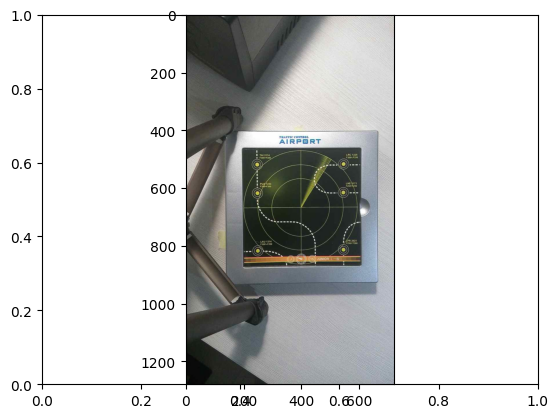

In [4]:
images_path = '../data/datasets/field-detection/images'
filenames = os.listdir(images_path)
filename = os.path.join(images_path, filenames[8])

img = imread_numpy(filename)
imshow_numpy(img)

results = ipro.process(img)

In [5]:
results['field']['results'].keys()

dict_keys(['level', 'matrix', 'roads', 'masks', 'mask', 'matrix_cls', 'matrix_dir'])

In [6]:
results['field']['results']['matrix']

[['u', '.', '.', 'l'],
 ['u', '.', '.', 'r'],
 ['.', '.', '.', '.'],
 ['l', '.', '.', 'd']]

In [7]:
results['field']['results']['roads']

[[(0, 0), (1, 0)], [(0, 3), (1, 3)], [(3, 3)], [(3, 0)]]

In [8]:
results['field']['solution']

[['rwr', 'rwr', 'owo', 'owo'],
 ['wrw', 'wrw', 'bwb', 'bwb'],
 ['wrw', 'wbw', 'gwg', 'bwb'],
 ['wbw', 'wbw', 'gwg', 'gwg']]

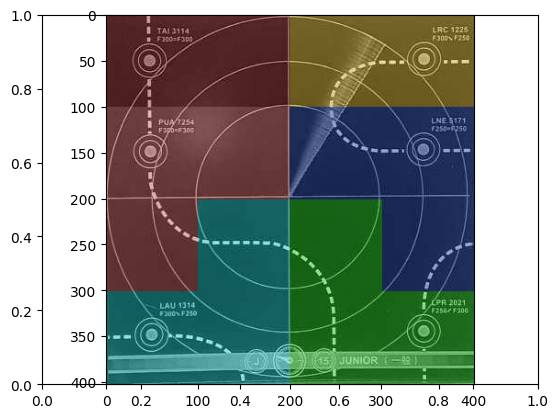

In [9]:
imshow_numpy(results['field']['ans_img'])